# Projekt końcowy - analiza danych meteorologicznych

#### Patryk Twardosz, Michał Ślęzak

In [283]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from typing import List

year = 2022
names = ['Date', 'TempAvg', 'TempMin', 'TempMax', 'Rain', 'Snow', 'WindDir', 'WindSpeed', 'WindSpeedMax', 'Pressure', 'Sunshine']

Import bibliotek. Podanie nazw kolumn oraz podanie roku dla którego analizujemy dane

In [284]:
def analize(df):
  """Przedstawienie podstawowych informacji o danych w DataFrame"""
  print(df.head())
  print(df.describe())
  print(df.head(10))
  print(df.dtypes)
  print(df.shape)

def cleanup(df):
  """Wyczyszczenie danych z NaN i zbędnych kolumn"""
  print(df.isna().sum())
  
  df.dropna(thresh=int(len(df) * 0.2), axis=1, inplace=True)
  
  print(df.isna().sum())
  print(df.shape)

  return df.copy()

def plot_df(df_NoNaN):
  """Wykresy dla danych z DataFrame"""
  cityName = df_NoNaN['City'].iloc[0]

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=False)
  fig.suptitle(f'{cityName} - {year}')


  ax1.set_title('Temperature')
  plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
  sns.lineplot(data=df_NoNaN, x='Date', y='TempAvg', label='TempAvg', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMin', label='TempMin', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMax', label='TempMax', ax=ax1)

  if 'Pressure' in df_NoNaN:
    ax2.set_title('Pressure')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Pressure', ax=ax2)
  else:
    print('No Pressure data')
  
  if 'WindSpeed' in df_NoNaN or 'WindSpeedMax' in df_NoNaN:
    ax3.set_title('Wind Speed')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

    if 'WindSpeed' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeed', label='Wind Speed', ax=ax3)
    
    if 'WindSpeedMax' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeedMax', label='Max Wind Speed', ax=ax3)
  else:
    print('No Wind Speed data')

  if 'Rain' in df_NoNaN:
    ax4.set_title('Rain')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Rain', ax=ax4)
  else:
    print('No Rain data')

  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
  plt.setp(ax4.xaxis.get_majorticklabels(), rotation=90)
    
  plt.show()


def lagrange_interpolation_manual(x_points, y_points, x):
    """Obliczanie wartości interpolowanej dla punktu x za pomocą interpolacji Lagrange'a."""
    n = len(x_points)
    result = 0
    for i in range(n):
        xi, yi = x_points[i], y_points[i]
        p = 1
        for j in range(n):
            xj = x_points[j]
            if i != j:
                p *= (x - xj) / (xi - xj)
        result += p * yi
    return result

def interpolate_column(series, column_name):
    """Interpolacja brakujących wartości w kolumnie za pomocą interpolacji Lagrange'a."""
    n = len(series)
    
    for idx in range(n):
        if pd.isna(series[idx]):
            left_idx, right_idx = idx - 1, idx + 1
            left_points, right_points = [], []
            
            while len(left_points) < 2 and left_idx >= 0:
                if not pd.isna(series[left_idx]):
                    left_points.insert(0, (left_idx, series[left_idx]))
                left_idx -= 1
            
            while len(right_points) < 2 and right_idx < n:
                if not pd.isna(series[right_idx]):
                    right_points.append((right_idx, series[right_idx]))
                right_idx += 1
            
            if len(left_points) + len(right_points) >= 2:
                x, y = zip(*left_points + right_points)
                interpolated_value = lagrange_interpolation_manual(x, y, idx)
                # Ensure minimum value is 0 for Rain and WindSpeed columns
                if column_name in ['Rain', 'WindSpeed'] and interpolated_value < 0:
                    interpolated_value = 0
                series.iat[idx] = interpolated_value
    
    return series

def interpolate_dataframe(df):
    """Interpolacja brakujących wartości w kolumnach numerycznych za pomocą interpolacji Lagrange'a."""
    for column in df.columns:
        if is_numeric_dtype(df[column]):
            df[column] = interpolate_column(df[column], column)
    return df

def introduce_random_nans(df, nan_fraction=0.05):
    """Wprowadzenie losowych NaNów do DataFrame."""
    # Columns where NaNs can be introduced
    target_columns = ['TempAvg', 'Rain', 'WindSpeed', 'Pressure']
    
    # Total number of elements in the target columns
    target_indices = [df.columns.get_loc(col) for col in target_columns if col in df.columns]
    target_element_count = len(target_indices) * (df.shape[0] - 4)  # Avoiding the first two and last two rows

    # Calculate number of NaNs to introduce
    nan_count = int(np.floor(nan_fraction * target_element_count))

    # Generate available indices within target columns, excluding the first and last two rows
    all_indices = np.array([
        row * df.shape[1] + col 
        for row in range(2, df.shape[0] - 2)
        for col in target_indices
    ])
    
    nan_indices = np.random.choice(all_indices, nan_count, replace=False)
    
    # Flatten the DataFrame values and introduce NaNs
    flat_df = df.values.flatten()
    flat_df[nan_indices] = np.nan
    
    # Reshape back to the original DataFrame shape
    df_with_nans = pd.DataFrame(flat_df.reshape(df.shape), columns=df.columns)
    df_with_nans = df_with_nans.astype(df.dtypes)

    print(df_with_nans.isna().sum())
    
    return df_with_nans, nan_indices

def calculate_interpolation_error(original_df, interpolated_df, nan_indices):
    """Obliczanie błędów interpolacji dla DataFrame."""
    # Initialize the error dataframe
    error_df = pd.DataFrame(columns=['Row', 'Column', 'Error'])
    
    rows, cols = original_df.shape
    error_records = []

    # Calculate the error for each nan_index
    for i, flat_idx in enumerate(nan_indices):
        row_idx = flat_idx // cols
        col_idx = flat_idx % cols
        
        original_value = original_df.iloc[row_idx, col_idx]
        interpolated_value = interpolated_df.iloc[row_idx, col_idx]
        
        if isinstance(original_value, (float, int)) and not pd.isna(original_value) and \
           isinstance(interpolated_value, (float, int)) and not pd.isna(interpolated_value):
            error = abs(original_value - interpolated_value)
            error_records.append({'Row': row_idx, 'Column': original_df.columns[col_idx], 'Error': error})

    error_df = pd.DataFrame(error_records)
    
    return error_df

def plot_interpolation_error(error_df, cityName):
    """Wykres błędów interpolacji."""
    if error_df.empty:
        print("No interpolation errors to plot.")
        return

    columns_to_plot = ['TempAvg', 'Pressure', 'WindSpeed', 'Rain']
    filtered_df = error_df[error_df['Column'].isin(columns_to_plot)]
    
    if filtered_df.empty:
        print("No interpolation errors for the specified columns.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{cityName} - {year}')
    axes = axes.flatten()
    
    for ax, column in zip(axes, columns_to_plot):
        column_data = filtered_df[filtered_df['Column'] == column]['Error']
        if not column_data.empty:
            sns.boxplot(y=column_data, ax=ax)
            ax.set_title(f'Interpolation Error for {column}')
            ax.set_ylabel('Absolute Error')
        else:
            ax.set_title(f'No data for {column}')
            ax.set_ylabel('Absolute Error')
            ax.set_xticks([])  # Hide x-ticks when no data is present
    
    plt.tight_layout()
    plt.show()

Zbiór funkcji wykorzystywanych do analizy i obróbki danych. Podczas obróbki zastosowano:
 - Usunięcie kolumn gdzie ilość NaN'ów przekraczała 80% danych.
 - Wizualizacja załadowanych i wstępnie obriobionych danych.
 - Na potrzeby zastosowania interpolacji zamieniono dodatkowo 5% danych na NaN'y
 - Zastosowanie interpolacji Lagrange'a w celu obliczenia brakujących danych
 - Narysowanie wykresów błędu (porównanie wartości obliczonych z wartościami w tych miejscach przed ich usunięciem)

Każda funkcja posiada dodatkowo swój opis działania

In [285]:
def read_csv(filename, city_name):
  """Wczytanie danych z pliku CSV i wybranie danych z danego roku i miasta"""
  df = pd.read_csv(filename, delimiter=',', names=names, skiprows=1)  # skipping header row
  df['Date'] = pd.to_datetime(df['Date'])
  df = df[df['Date'].dt.year == year]
  df['City'] = city_name
  return df

In [286]:


# Load the data for multiple cities
df_Krakow = read_csv('Krakow.csv',    'Krakow')
df_Warsaw = read_csv('Warszawa.csv',  'Warszawa')
df_Szczec = read_csv('Szczecin.csv',  'Szczecin')
df_Gdansk = read_csv('Gdansk.csv',    'Gdansk')
df_Podlas = read_csv('Bialystok.csv', 'Bialystok')

city_coords = {
  'Krakow':    (19.94, 50.06),
  'Warszawa':  (21.01, 52.23),
  'Szczecin':  (14.55, 53.43),
  'Gdansk':    (18.65, 54.35),
  'Bialystok': (23.16, 53.13),
}

def run(df):
  """Główna funkcja do analizy danych i interpolacji."""
  analize(df)
  df_NoNaN = cleanup(df)
  plot_df(df_NoNaN)
  df_with_nans, nan_indices = introduce_random_nans(df_NoNaN.copy(), nan_fraction=0.05)
  df_interpolated = interpolate_dataframe(df_with_nans.copy())
  error_df = calculate_interpolation_error(df_NoNaN.copy(), df_interpolated.copy(), nan_indices)
  plot_interpolation_error(error_df, df_NoNaN['City'].iloc[0])
  plot_df(df_interpolated)

  return df_interpolated


In [287]:
df_Krakow.head()

,Date,TempAvg,TempMin,TempMax,Rain,Snow,WindDir,WindSpeed,WindSpeedMax,Pressure,Sunshine,City
17430,2022-01-01,9.7,9.0,11.4,6.4,NaN,238.0,19.2,42.6,1021.0,NaN,Krakow
17431,2022-01-02,8.6,6.0,11.1,2.0,NaN,224.0,8.8,37.0,1018.7,NaN,Krakow
17432,2022-01-03,8.7,5.7,10.9,0.0,NaN,231.0,29.1,55.5,1010.0,NaN,Krakow
17433,2022-01-04,8.0,5.0,10.9,NaN,NaN,207.0,11.0,35.2,1001.0,NaN,Krakow
17434,2022-01-05,4.8,1.3,11.5,2.0,NaN,231.0,15.8,37.0,1001.1,NaN,Krakow


Przykładowy wygląd danych po załadowaniu dla miasta Kraków

In [288]:
df_Krakow.dtypes

Date            datetime64[ns]
TempAvg                float64
TempMin                float64
TempMax                float64
Rain                   float64
Snow                   float64
WindDir                float64
WindSpeed              float64
WindSpeedMax           float64
Pressure               float64
Sunshine               float64
City                    object
dtype: object

Typy danych po załdowaniu dla przykładowego miasta Kraków

In [289]:
df_Krakow.isna().sum()

Date              0
TempAvg           0
TempMin           0
TempMax           0
Rain             43
Snow            342
WindDir           0
WindSpeed         0
WindSpeedMax     11
Pressure          0
Sunshine        365
City              0
dtype: int64

Ilość NaN'ów w danych dla miasta Kraków

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
17430 2022-01-01      9.7      9.0     11.4   6.4   NaN    238.0       19.2   
17431 2022-01-02      8.6      6.0     11.1   2.0   NaN    224.0        8.8   
17432 2022-01-03      8.7      5.7     10.9   0.0   NaN    231.0       29.1   
17433 2022-01-04      8.0      5.0     10.9   NaN   NaN    207.0       11.0   
17434 2022-01-05      4.8      1.3     11.5   2.0   NaN    231.0       15.8   

       WindSpeedMax  Pressure  Sunshine    City  
17430          42.6    1021.0       NaN  Krakow  
17431          37.0    1018.7       NaN  Krakow  
17432          55.5    1010.0       NaN  Krakow  
17433          35.2    1001.0       NaN  Krakow  
17434          37.0    1001.1       NaN  Krakow  
                                Date     TempAvg     TempMin     TempMax  \
count                            365  365.000000  365.000000  365.000000   
mean   2022-07-01 23:59:59.999999744    9.817534    5.044110   14.819452 

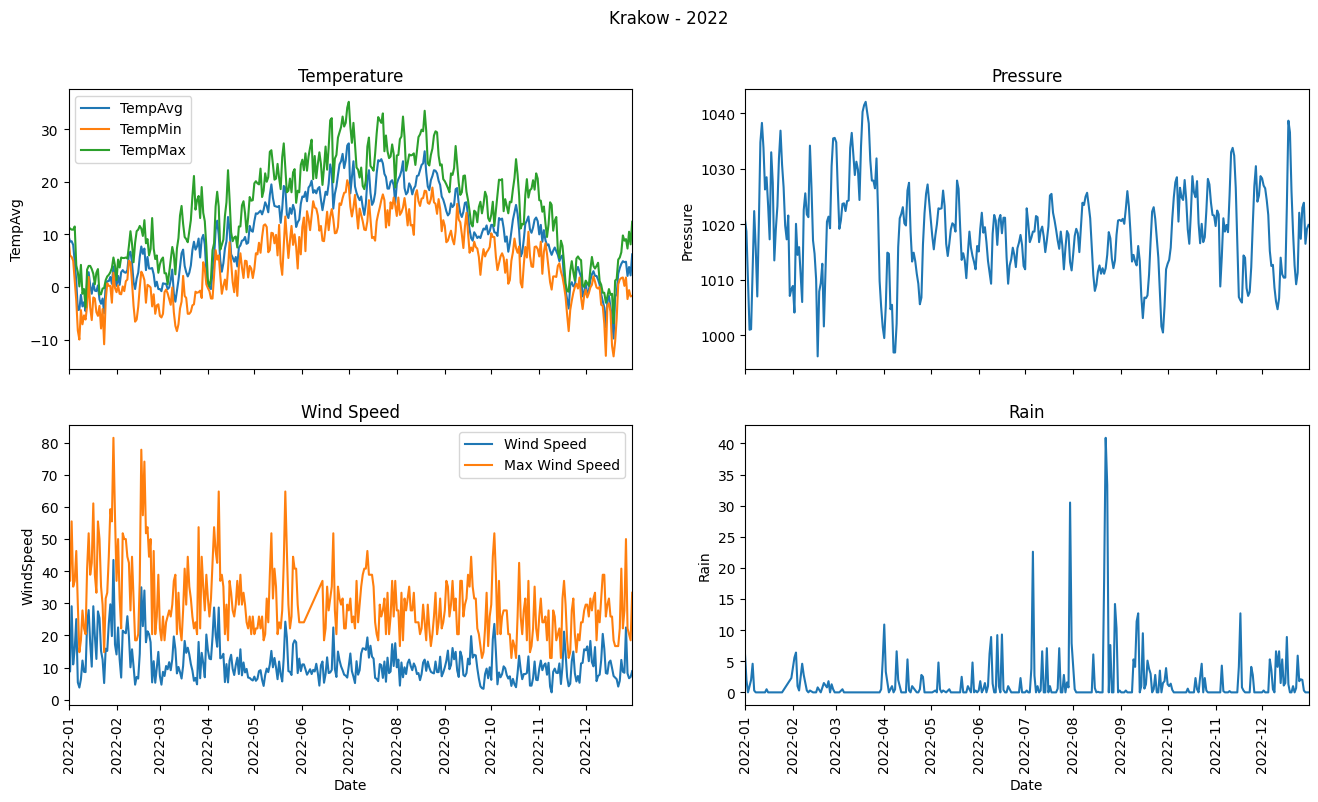

Date             0
TempAvg         16
TempMin          0
TempMax          0
Rain            53
WindDir          0
WindSpeed       20
WindSpeedMax    11
Pressure        22
City             0
dtype: int64


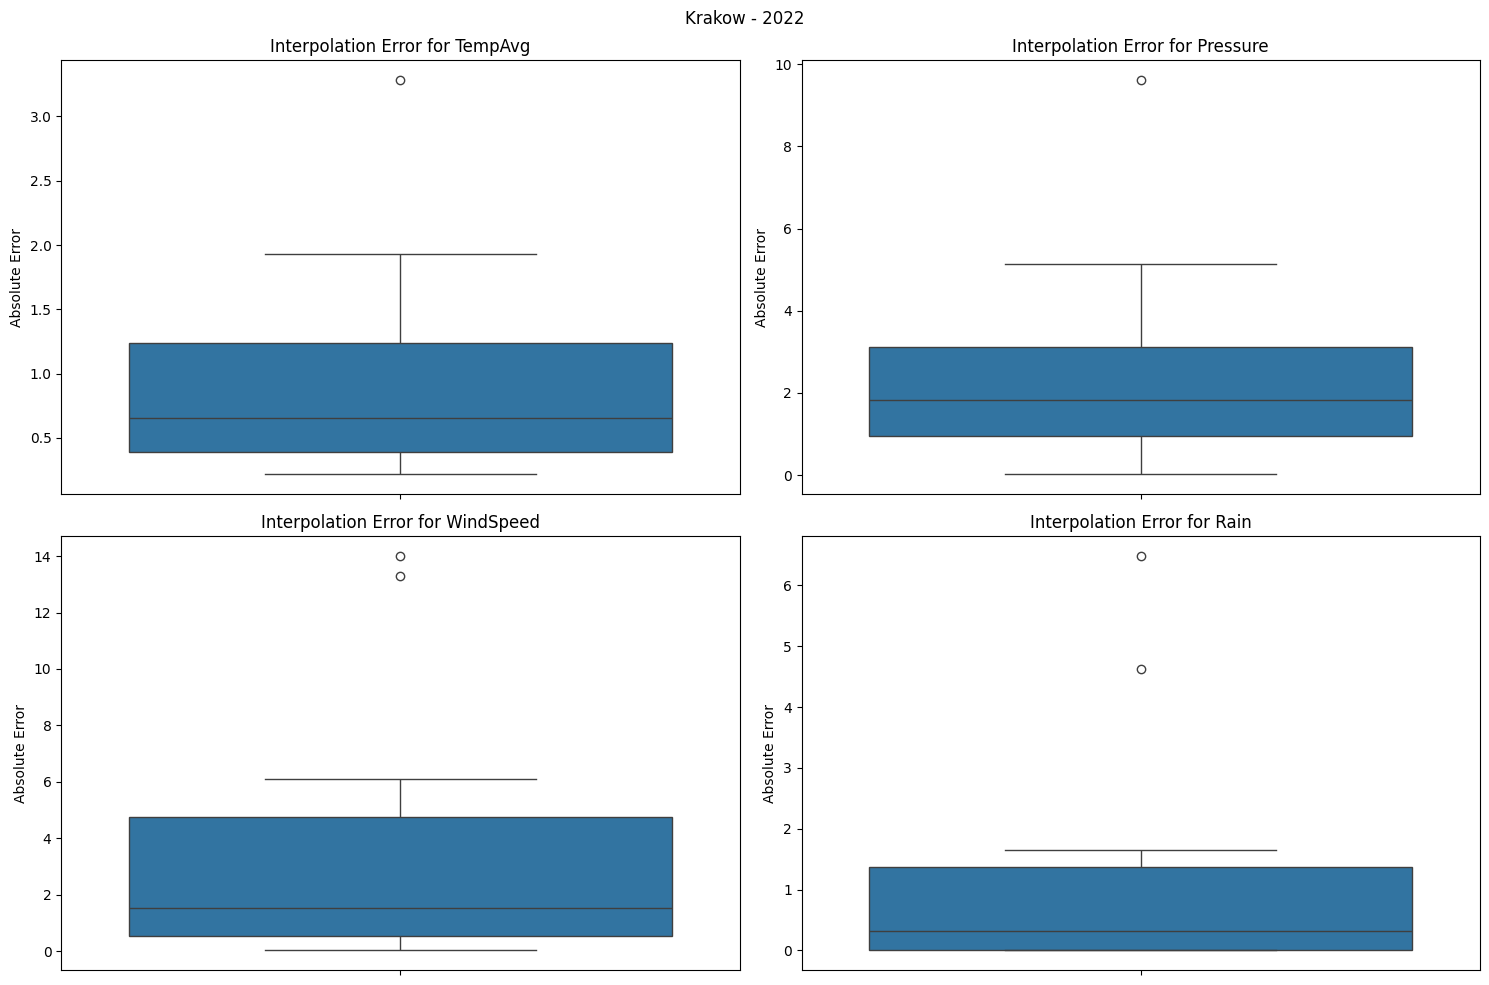

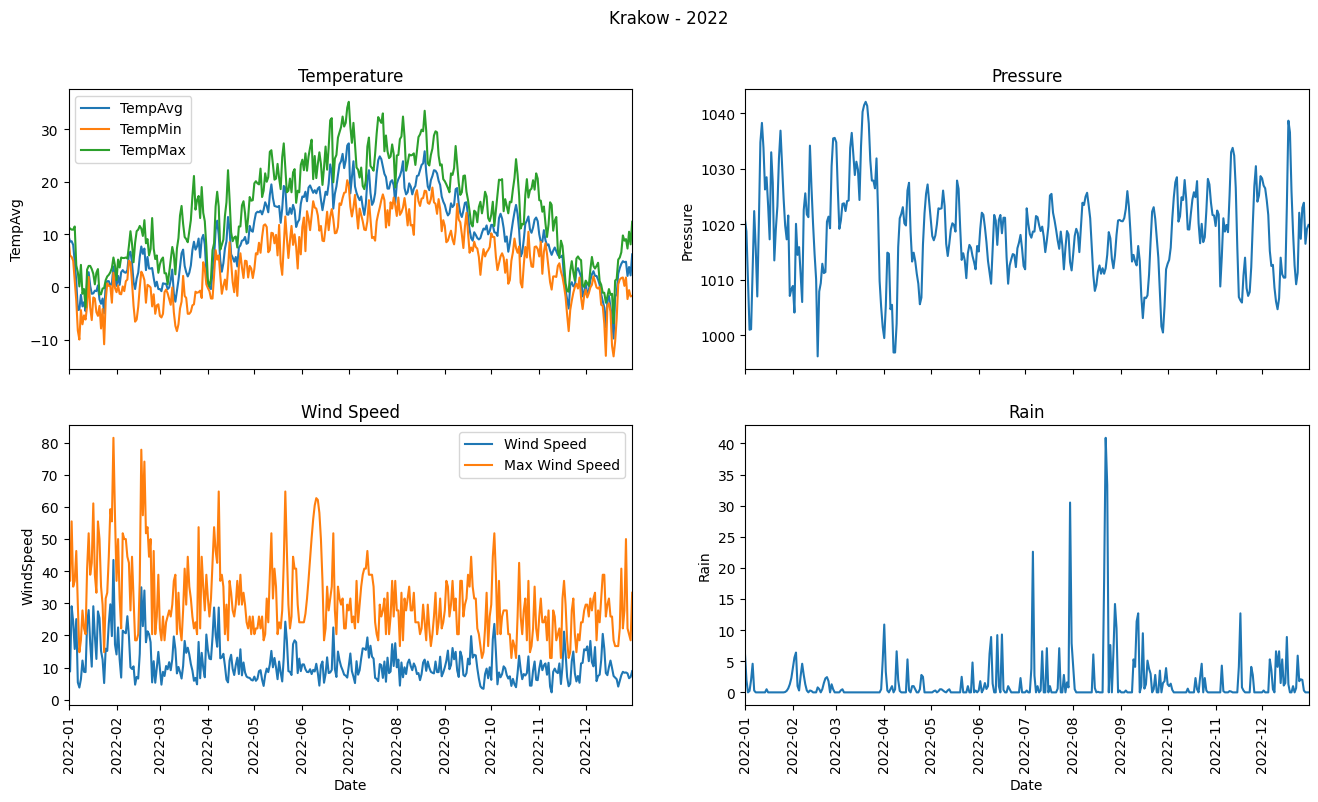

In [290]:
interpolatedDF_Krakow = run(df_Krakow)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
21901 2022-01-01      8.0      4.1     11.3   7.6   NaN    292.0       17.9   
21902 2022-01-02      6.7      3.6      9.7   NaN   NaN    176.0        9.0   
21903 2022-01-03      7.8      6.4     10.5   NaN   NaN    258.0       20.4   
21904 2022-01-04      6.0      4.2      7.2   NaN   NaN    189.0        8.4   
21905 2022-01-05      4.2      2.2      7.4   6.4   NaN    239.0       11.4   

       WindSpeedMax  Pressure  Sunshine      City  
21901          37.0    1017.3       NaN  Warszawa  
21902          35.2    1015.1       NaN  Warszawa  
21903          51.8    1004.0       NaN  Warszawa  
21904          27.8     998.1       NaN  Warszawa  
21905          31.5     997.5       NaN  Warszawa  
                                Date     TempAvg     TempMin     TempMax  \
count                            365  365.000000  365.000000  365.000000   
mean   2022-07-01 23:59:59.999999744    9.982466    5.812877 

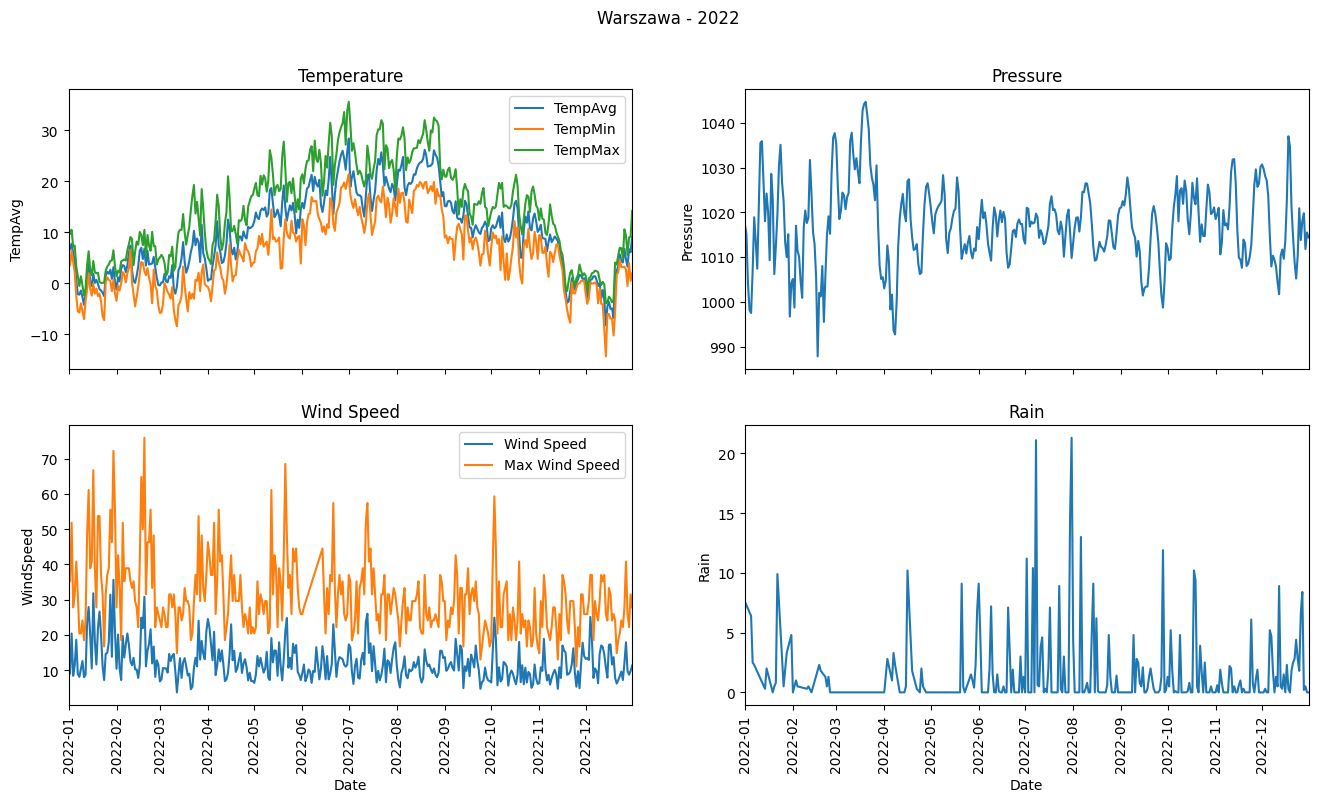

Date             0
TempAvg         14
TempMin          0
TempMax          0
Rain            97
WindDir          0
WindSpeed       14
WindSpeedMax    11
Pressure        28
City             0
dtype: int64


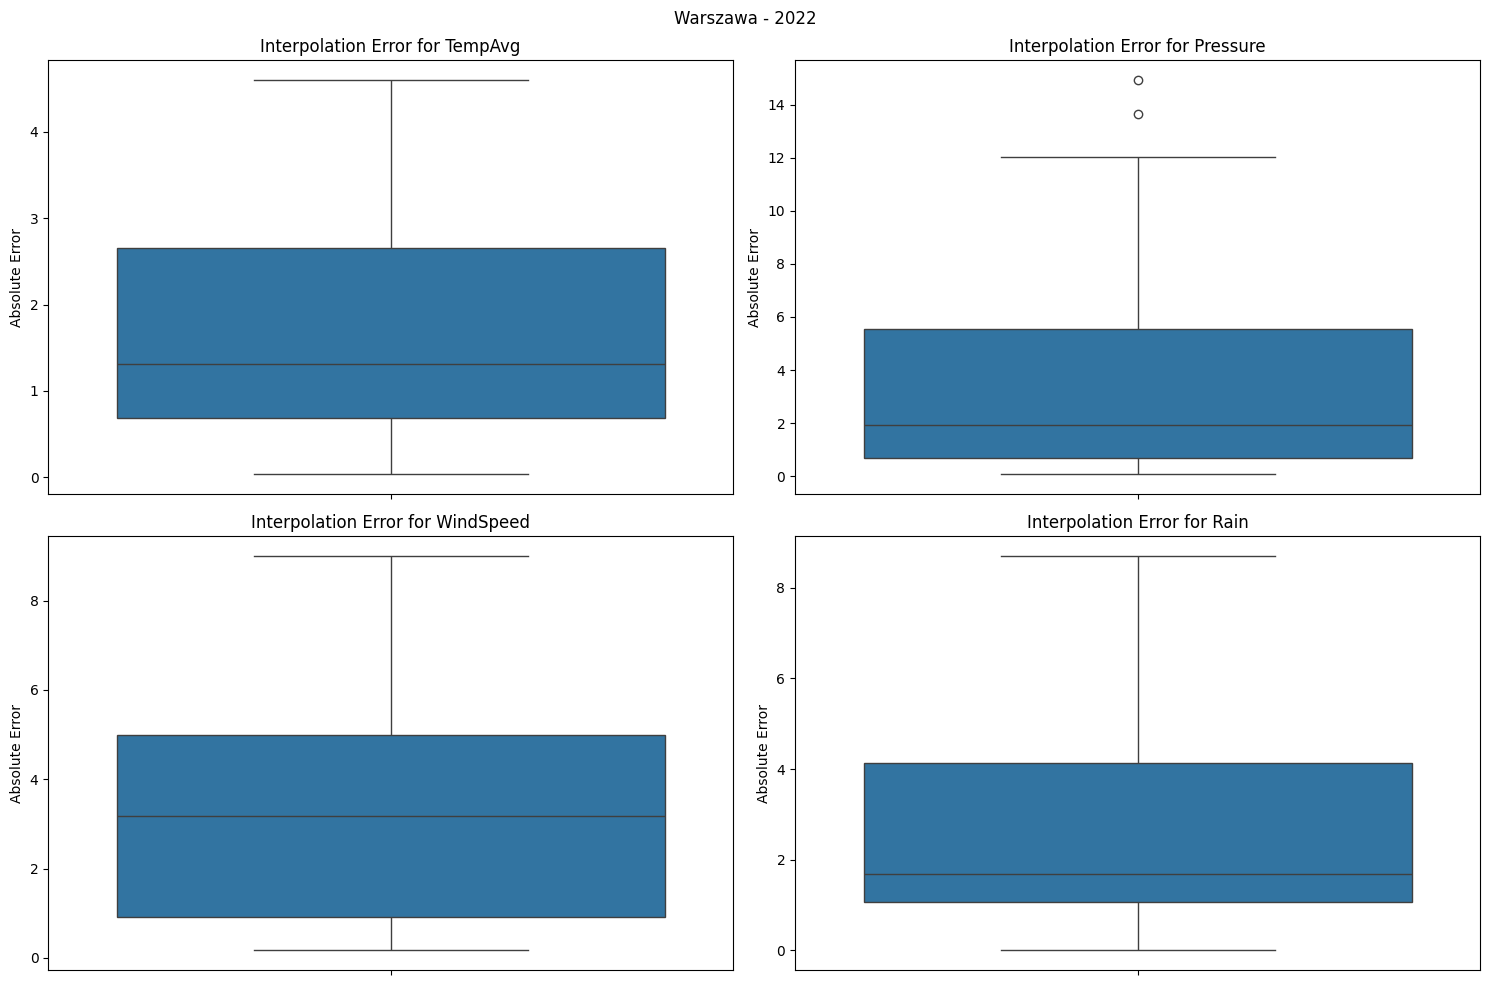

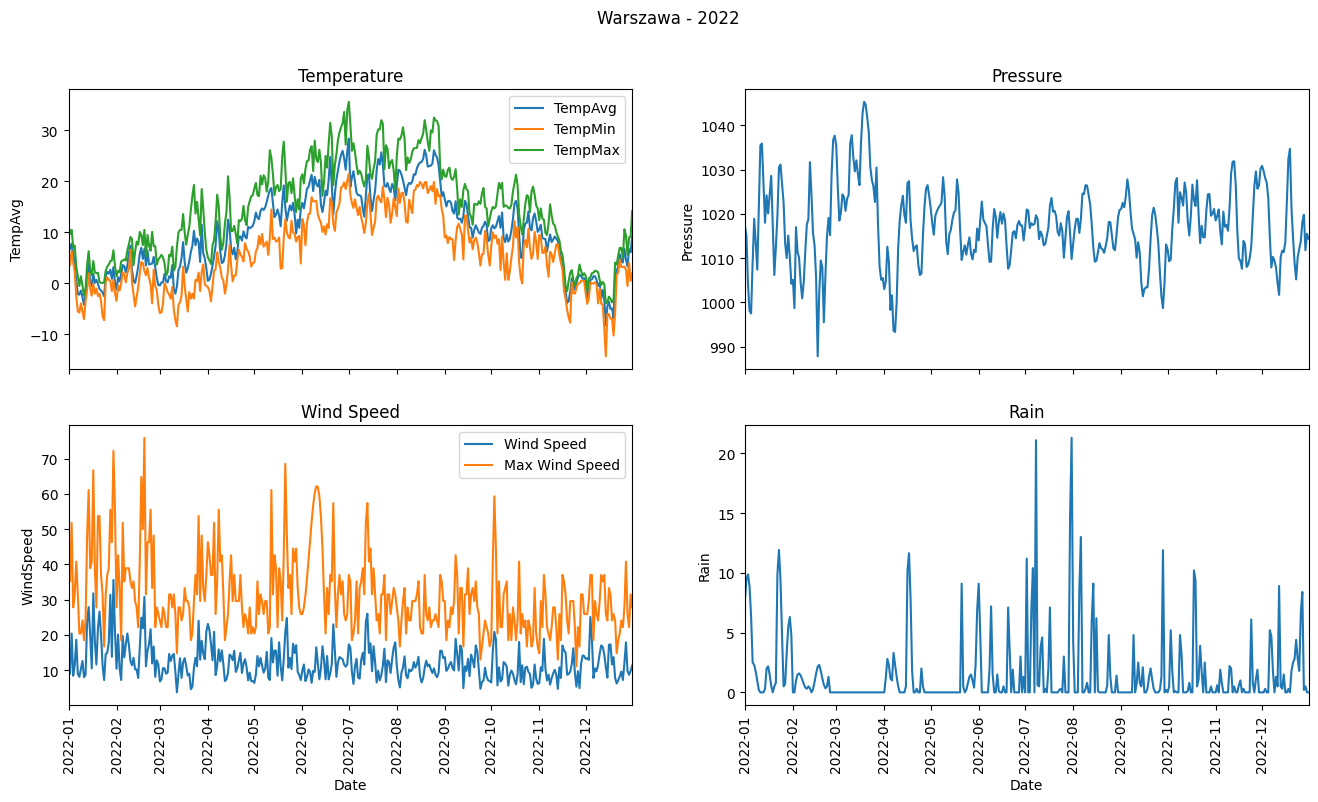

In [291]:
interpolatedDF_Warsaw = run(df_Warsaw)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
25699 2022-01-01     10.1     10.0     11.8   4.1   NaN    260.0       13.7   
25700 2022-01-02      9.9      8.0     11.8   0.3   NaN    204.0       16.4   
25701 2022-01-03      7.4      6.0     11.8   5.1   NaN    233.0       13.2   
25702 2022-01-04      5.4      3.0      7.4   5.3   NaN    212.0       12.4   
25703 2022-01-05      2.1      1.0      6.6   0.5   NaN    216.0       15.1   

       WindSpeedMax  Pressure  Sunshine      City  
25699          27.8    1018.6       NaN  Szczecin  
25700          46.3    1009.6       NaN  Szczecin  
25701          38.9    1003.2       NaN  Szczecin  
25702          33.3     994.8       NaN  Szczecin  
25703          42.6     994.7       NaN  Szczecin  
                                Date     TempAvg     TempMin     TempMax  \
count                            365  365.000000  365.000000  365.000000   
mean   2022-07-01 23:59:59.999999744    9.978904    5.343014 

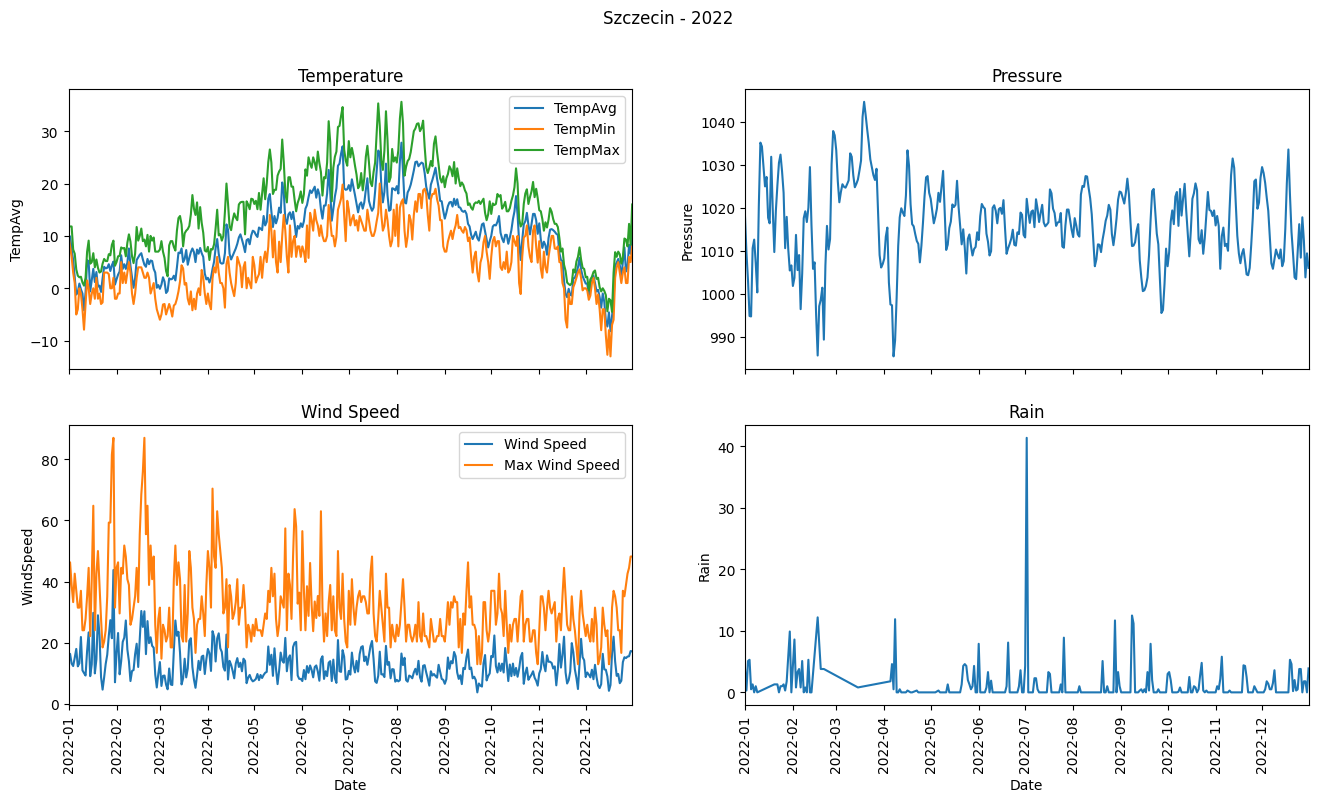

Date             0
TempAvg         20
TempMin          0
TempMax          0
Rain            81
WindDir          0
WindSpeed       19
WindSpeedMax     0
Pressure        16
City             0
dtype: int64


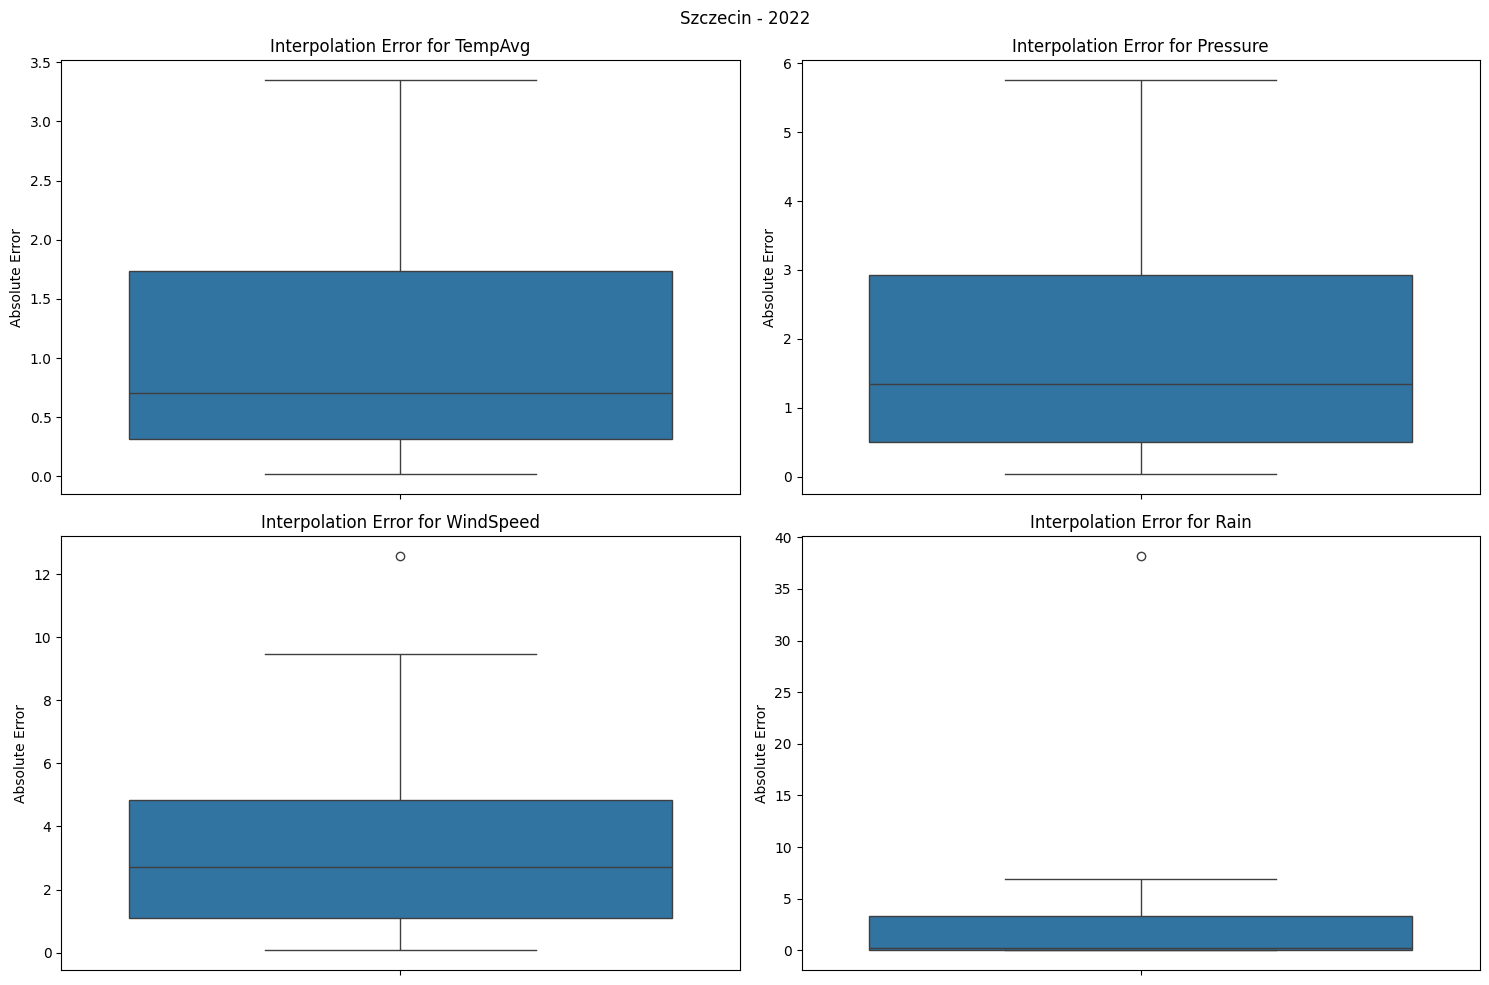

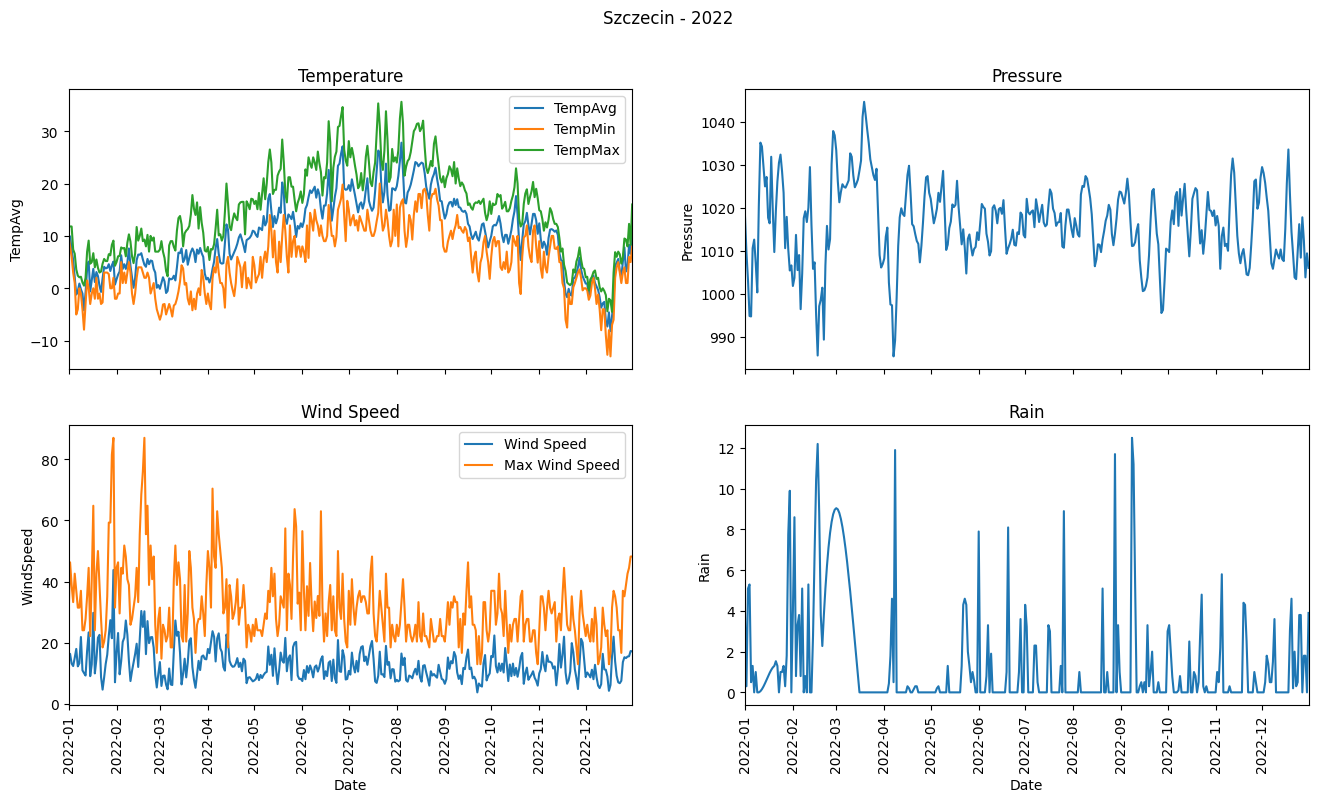

In [292]:
interpolatedDF_Szczec = run(df_Szczec)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
10444 2022-01-01      5.1      3.0      7.0   NaN   NaN    315.0       19.5   
10445 2022-01-02      7.2      3.0     10.0   NaN   NaN    222.0       19.7   
10446 2022-01-03      6.6      5.0      8.0   NaN   NaN    265.0       25.7   
10447 2022-01-04      5.1      5.0      6.0   NaN   NaN    216.0       17.2   
10448 2022-01-05      2.0      1.0      4.0   NaN   NaN    242.0       20.8   

       WindSpeedMax  Pressure  Sunshine    City  
10444          37.0    1016.4       NaN  Gdansk  
10445          44.5    1007.7       NaN  Gdansk  
10446          48.2     999.4       NaN  Gdansk  
10447          37.0     993.2       NaN  Gdansk  
10448          35.2     992.3       NaN  Gdansk  
                                Date     TempAvg     TempMin     TempMax  \
count                            365  365.000000  365.000000  365.000000   
mean   2022-07-01 23:59:59.999999744    8.761918    5.075616   12.358904 

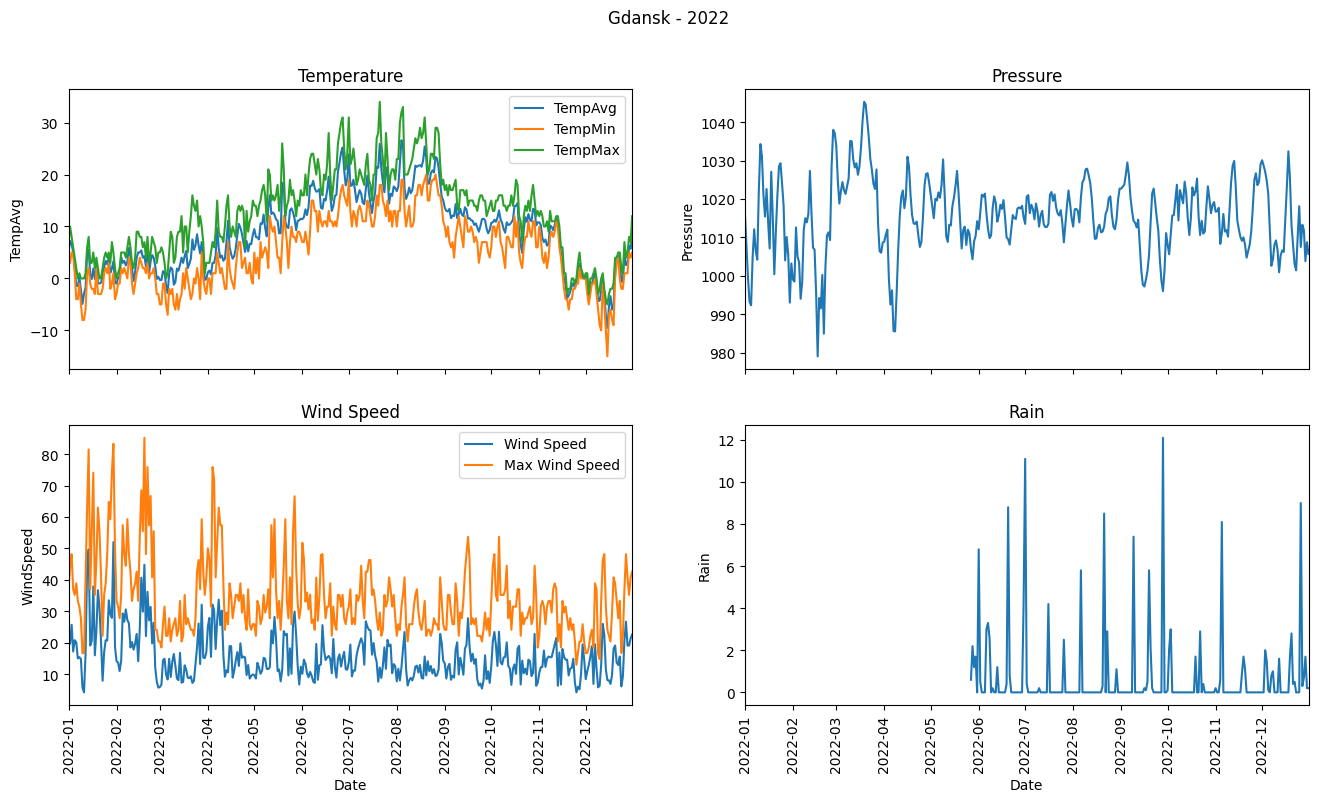

Date              0
TempAvg          19
TempMin           0
TempMax           0
Rain            158
WindDir           0
WindSpeed        15
WindSpeedMax      0
Pressure         21
City              0
dtype: int64


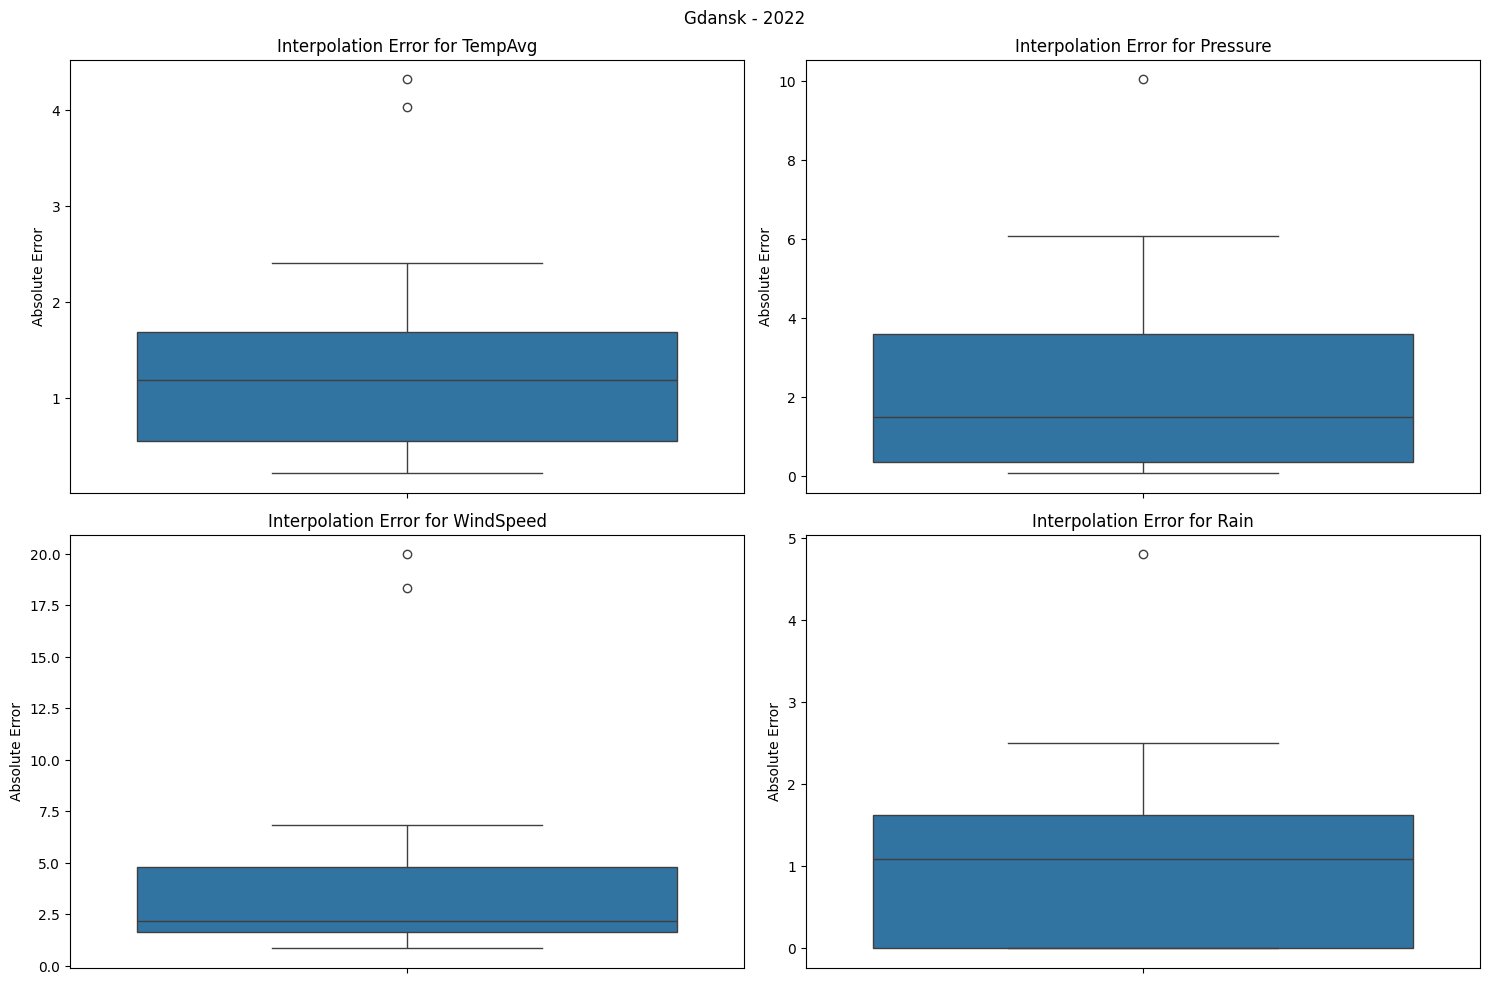

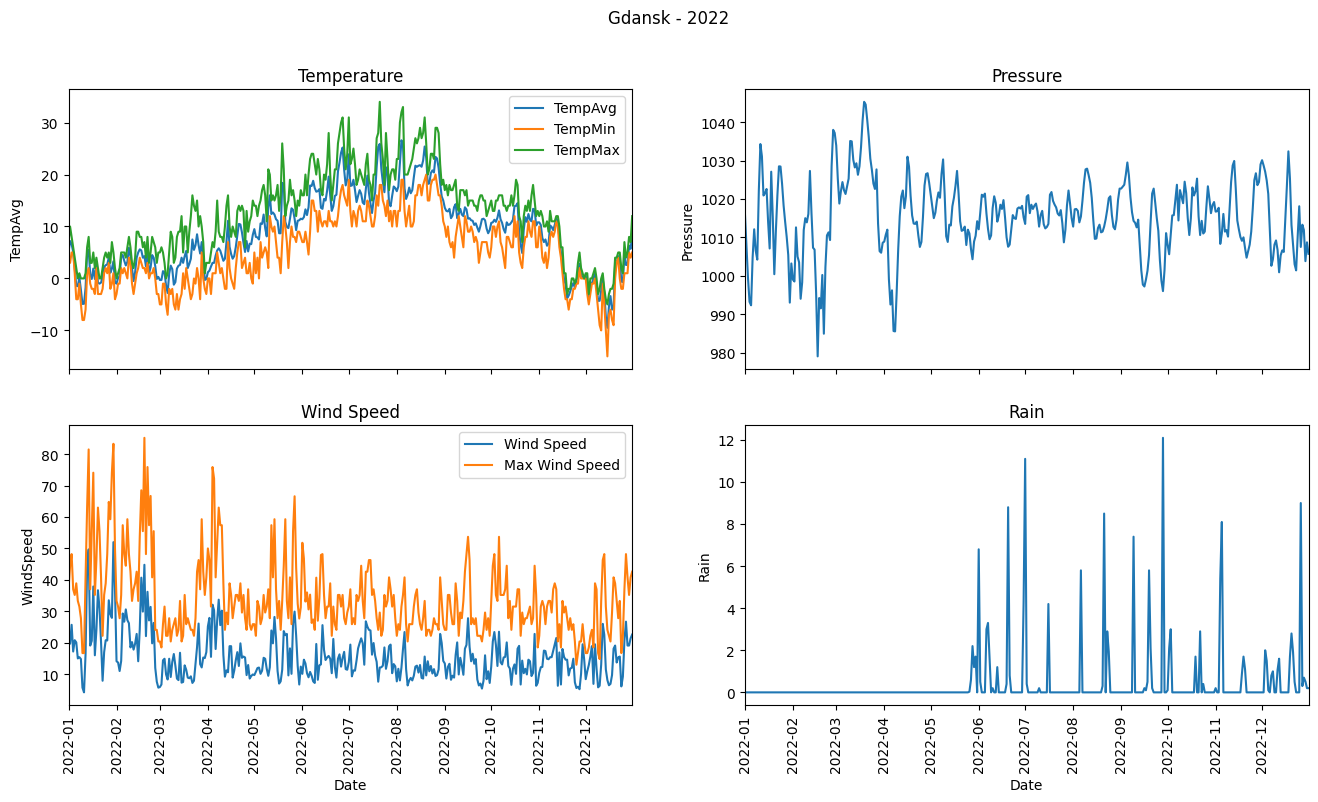

In [293]:
interpolatedDF_Gdansk = run(df_Gdansk)

            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
21801 2022-01-01      4.5      0.1      9.7  10.9   NaN    301.0       10.4   
21802 2022-01-02      2.3     -1.0      8.5   NaN   NaN    201.0        8.6   
21803 2022-01-03      6.8      5.9      8.7   7.1   NaN    265.0       14.3   
21804 2022-01-04      4.9      4.0      6.0   2.3   NaN    206.0        7.5   
21805 2022-01-05      2.4      0.2      4.8   9.4   NaN    249.0        7.4   

       WindSpeedMax  Pressure  Sunshine       City  
21801          29.6    1015.0       NaN  Bialystok  
21802          25.9    1014.5       NaN  Bialystok  
21803          42.6    1000.3       NaN  Bialystok  
21804          24.1     998.0       NaN  Bialystok  
21805          20.4     995.7       NaN  Bialystok  
                                Date     TempAvg     TempMin     TempMax  \
count                            365  365.000000  365.000000  365.000000   
mean   2022-07-01 23:59:59.999999744    8.261644    3.7

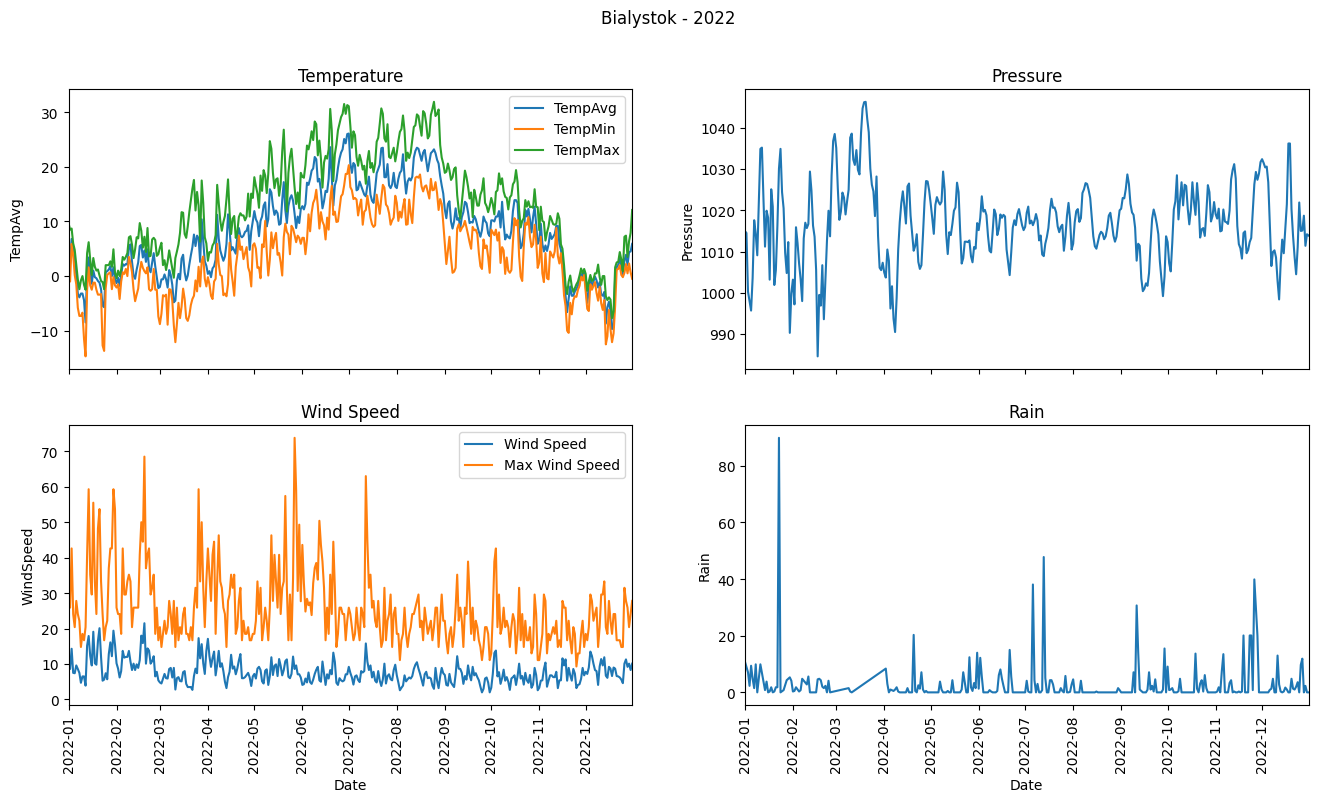

Date             0
TempAvg         16
TempMin          0
TempMax          0
Rain            59
WindDir          0
WindSpeed       21
WindSpeedMax     0
Pressure        16
City             0
dtype: int64


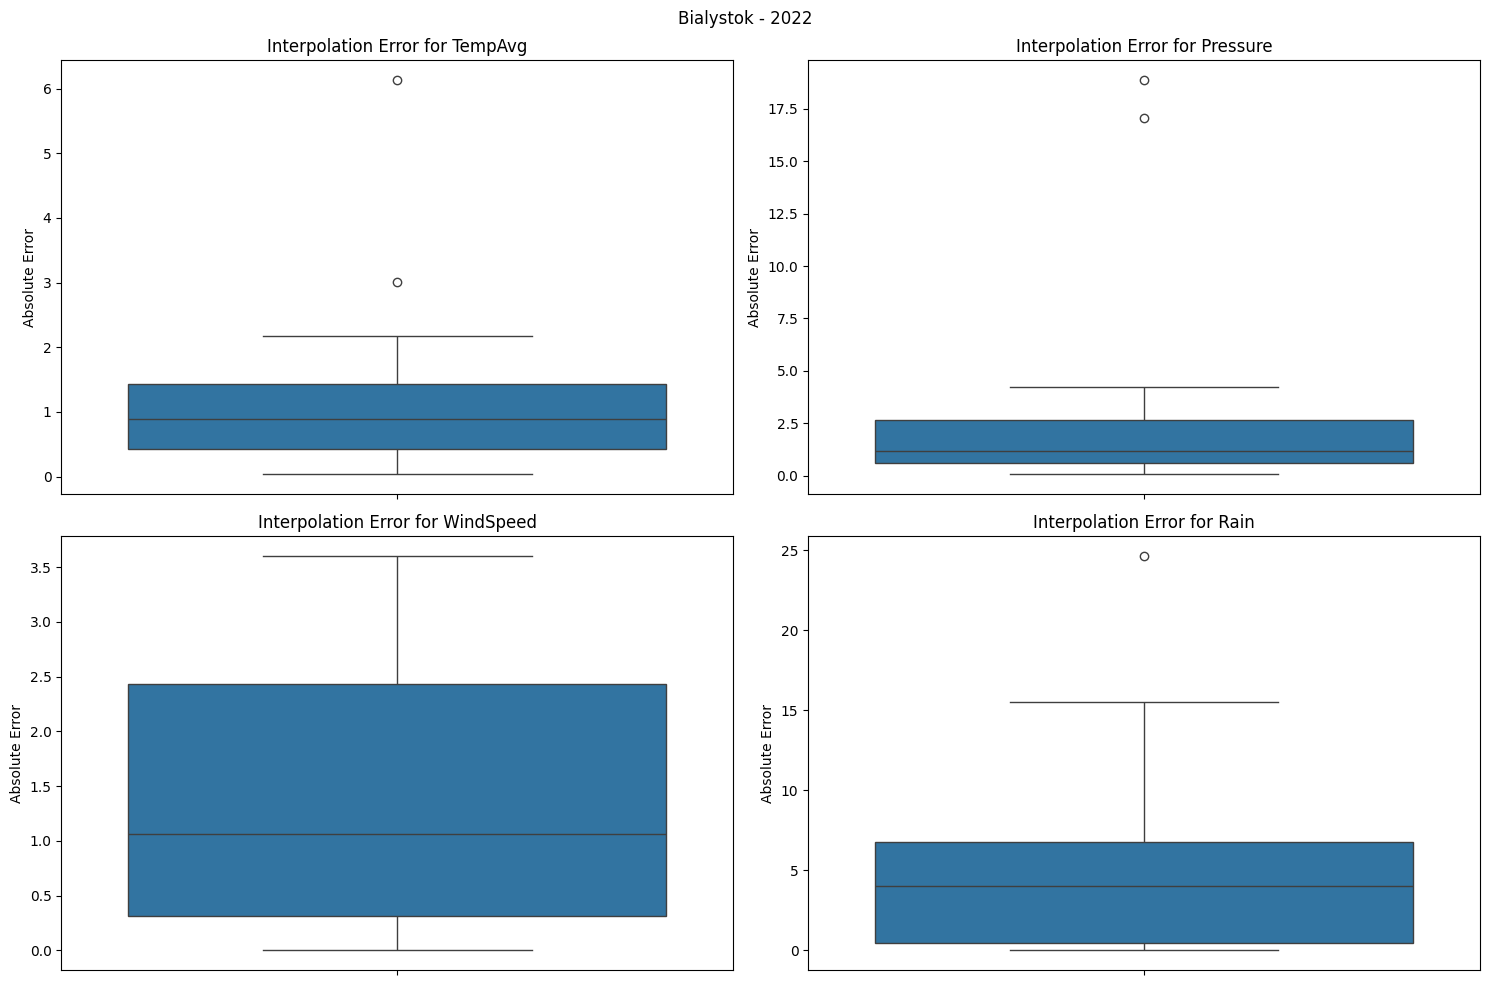

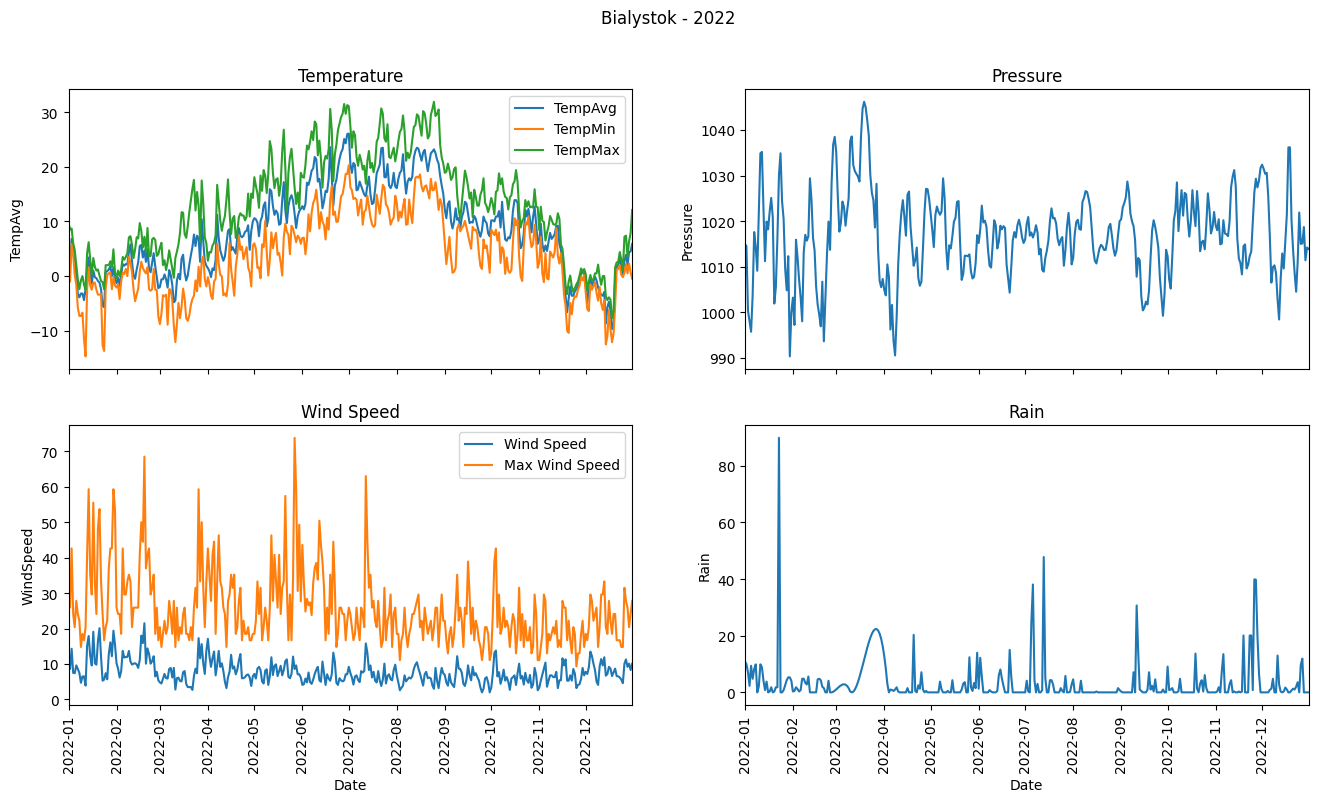

In [294]:
interpolatedDF_Podlas = run(df_Podlas)

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from ipywidgets import interact, widgets

# Concatenate all data into a single DataFrame
data = pd.concat([interpolatedDF_Krakow, interpolatedDF_Warsaw, interpolatedDF_Szczec, interpolatedDF_Gdansk, interpolatedDF_Podlas])

# Function to create a map for the selected date
def plot_temperature(date, type):
    df = data[data['Date'] == pd.Timestamp(date)]
    
    if df.empty:
        print(f"No data available for {date}")
        return
    
    # Generate a grid for interpolation
    grid_lon, grid_lat = np.mgrid[14:25:10j, 49:55:10j]
    
    # Interpolate the data onto the grid
    grid_temp = griddata((df['lon'], df['lat']), df[type], (grid_lon, grid_lat), method='cubic', rescale=True)
    
    # Create the map
    plt.figure(figsize=(12, 6))

    proj = ccrs.PlateCarree() # LambertAzimuthalEqualArea()


    ax = plt.axes(projection=proj)
    ax.set_extent([14, 25, 49, 55], crs=proj)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    # Plot contours with fixed color bar limits and gradient colors
    contour = ax.contourf(grid_lon, grid_lat, grid_temp, 60, transform=proj, cmap='coolwarm')
    plt.colorbar(contour, ax=ax, orientation='vertical', label=type)
    
    for cityName in city_coords.keys():
        ax.text(city_coords[cityName][0], city_coords[cityName][1], cityName, transform=proj, fontsize=12, verticalalignment='center', color='black', zorder=6)
    
    
    # Add title
    plt.title(f'Weather Distribution in Poland on {date}')
    
    # Display the map
    plt.show()

# Create a date slider widget
date_slider = widgets.SelectionSlider(
    options=[date.strftime('%Y-%m-%d') for date in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')],
    description='Date',
    continuous_update=True
)

# Create type of map widget
map_type = widgets.Dropdown(
    options=['TempAvg', 'Rain', 'WindSpeed', 'Pressure'],
    value='TempAvg',
    description='Map type:',
    disabled=False,
)

fixed_city_coords = {
  'Krakow':    (20.04, 49.06),
  'Warszawa':  (21.01, 52.23),
  'Szczecin':  (13.35, 53.43),
  'Gdansk':    (17.65, 54.75),
  'Bialystok': (25.16, 53.13),
}

data['lon'] = data['City'].map(lambda city: fixed_city_coords[city][0])
data['lat'] = data['City'].map(lambda city: fixed_city_coords[city][1])

# Connect the widget to the function
interact(plot_temperature, date=date_slider, type=map_type)


interactive(children=(SelectionSlider(description='Date', options=('2022-01-01', '2022-01-02', '2022-01-03', '…

<function __main__.plot_temperature(date, type)>

Mapa rozkładu pogody dla Polski. Zastosowano gradient przejścia pmiędzy miastami. Isnieje możliwość wyśweitlenia temperatury, opadów, prędkości wiatru i ciśnienia.

## Wnioski i obserwacje

- <b>Efektywność czyszczenia danych:</b><br>
Krok czyszczenia skutecznie redukuje szum przez usunięcie kolumn z nadmiernymi brakującymi wartościami, co sprawia, że zestaw danych jest bardziej zarządzalny do analizy i interpolacji.

- <b>Dokładność interpolacji:</b><br>
Metoda interpolacji Lagrange'a efektywnie oszacowuje brakujące wartości, szczególnie gdy dostępne są wystarczające sąsiadujące punkty danych. W przypadku braku sąsiadujących danych interpolacja ta nie jest wstanie poprawnie obliczyć nowych wartości.

- <b>Analiza błędów:</b><br>
Analiza błędów interpolacji ujawnia dokładność metody. Wykresy pudełkowe dostarczają wgląd w rozkład błędów, pomagając zidentyfikować potencjalne wartości odstające lub systematyczne odchylenia.

- <b>Wizualizacja:</b><br>
Wizualizacje odgrywają kluczową rolę w zrozumieniu trendów danych i efektywności interpolacji. Wykresy liniowe parametrów meteorologicznych oraz wykresy pudełkowe błędów interpolacji oferują kompleksowy obraz zachowania danych.